# Cleaning and drop features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder


In [19]:
df = pd.read_csv('../data/data_cleaned.csv', sep=',')

# encode target variable: 0: dropout, 1: enrolled, 2: graduated
le = LabelEncoder()
df['Target_encoded'] = le.fit_transform(df['Target'])

# Drop 'Target' variable
df.drop('Target', axis = 1, inplace = True)

# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Course', 'Previous_qualification',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation','Target_encoded']

df[col] = df[col].astype('category')


stud_selected = df.drop(['Nationality', 'International', 'Educational_special_needs',], axis = 1)  
stud_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Marital_status                                4424 non-null   category
 1   Application_mode                              4424 non-null   category
 2   Application_order                             4424 non-null   int64   
 3   Course                                        4424 non-null   category
 4   Daytime/evening_attendance                    4424 non-null   int64   
 5   Previous_qualification                        4424 non-null   category
 6   Previous_qualification_grade                  4424 non-null   float64 
 7   Mother_qualification                          4424 non-null   category
 8   Father_qualification                          4424 non-null   category
 9   Mother_occupation                             4424 n


| **Prestazione media**    Compatta le due note in un’unica metrica di qualità.     
                                                          
| **Efficienza**          Normalizzi per il numero di unità: evita che chi segue più corsi sembri “peggiore” solo perché ha più valutazioni. 

| **Trend / miglioramento** Cattura se lo studente recupera o peggiora; spesso è più predittivo del valore assoluto.    
                       
| **Carico di lavoro**  Indicatori di impegno complessivo, utili per dropout-risk.                                                         

| **Flag di rischio precoce**    Variabile binaria che riassume il primo semestre.                                                                  


quando due set di variabili sono altamente correlati perché misurano lo stesso concetto a momenti diversi, trasforma le seconde in segnali di progresso (differenze, rapporti, medie); spesso è l’andamento, non il valore assoluto, a distinguere chi si laurea da chi abbandona.

0 → 1: quanto lo studente si presenta davvero agli esami.

Delta > 0: migliora l’impegno; <br>
Delta < 0: cala (segnale di rischio).

# Features imbalanced

In [3]:
cat_cols = stud_selected.select_dtypes(include='category')

# Check the number of unique values in each categorical column
for col in cat_cols.columns:
    n_val = stud_selected[col].nunique()
    print(f"{col}: {n_val} unique values")

Marital_status: 6 unique values
Application_mode: 18 unique values
Course: 17 unique values
Previous_qualification: 17 unique values
Mother_qualification: 29 unique values
Father_qualification: 34 unique values
Mother_occupation: 32 unique values
Father_occupation: 46 unique values
Target_encoded: 3 unique values


In [4]:
def imbalance_report(df: pd.DataFrame, cat_columns, rare_thresh=0.01):
    """
    Return a DataFrame with imbalance metrics for each categorical column.
    - dominant_share: % of the most frequent category
    - rare_share    : total % of categories below `rare_thresh`
    - n_categories  : number of distinct categories
    """
    rows = []
    for col in cat_columns:
        freqs = df[col].value_counts(normalize=True, dropna=False)
        dominant_share = freqs.iloc[0]
        rare_share = freqs[freqs < rare_thresh].sum()
        rows.append({
            "feature": col,
            "dominant_share": dominant_share,
            "rare_share": rare_share,
            "n_categories": len(freqs)
        })
    return pd.DataFrame(rows).set_index("feature")           \
                             .sort_values("dominant_share", ascending=False)

imbalance_df = imbalance_report(stud_selected, cat_cols, rare_thresh=0.01)
print(imbalance_df.head(16))    # show the most skewed first


                        dominant_share  rare_share  n_categories
feature                                                         
Marital_status                0.885850    0.007911             6
Previous_qualification        0.840190    0.035036            17
Target_encoded                0.499322    0.000000             3
Application_mode              0.386076    0.030515            18
Mother_occupation             0.356465    0.034358            32
Father_qualification          0.273282    0.040461            34
Mother_qualification          0.241637    0.029611            29
Father_occupation             0.228300    0.025316            46
Course                        0.173146    0.002712            17


| `dominant_share ≥ 0.85` | Variabile dominata da un’unica modalità → alto rischio che le altre colonne “valgano zero”. 

| `rare_share ≥ 0.20`     | Molte modalità con frequenza < 1 % → sparsità elevata in one-hot, possibile over-fitting. 
  
| `n_categories ≫ 50`     | Cardinalità alta, anche se distribuzione non estrema.                                       


**COLLAPSE RARE LEVELS**

In [5]:
THRESH = 0.01          # share below which a level is considered "rare" (1 %)

cat_cols = []
for col in stud_selected.columns:
    if stud_selected[col].dtype.name in ["category"]:
        cat_cols.append(col)

print(f"Categorical columns detected ({len(cat_cols)}): {cat_cols}")

# -------------------------------------------------------------------
# 2) Collapse rare levels into the new code "0"
# -------------------------------------------------------------------
for col in cat_cols:
    # Ensure the column is of pandas 'category' dtype
    stud_selected[col] = stud_selected[col].astype("category")

    # Share of each level (NaNs kept separate)
    freqs = stud_selected[col].value_counts(normalize=True, dropna=False)
    rare_levels = freqs[freqs < THRESH].index

    # Skip columns with no rare levels
    if rare_levels.empty:
        continue

    # Add the new category code (0) if it doesn't exist yet
    if 0 not in stud_selected[col].cat.categories:
        stud_selected[col] = stud_selected[col].cat.add_categories([0])

    # Replace every rare level with 0
    stud_selected[col] = stud_selected[col].where(~stud_selected[col].isin(rare_levels), 0)

    # Optional: drop categories that disappeared after the replacement
    stud_selected[col] = stud_selected[col].cat.remove_unused_categories()

    print(f"Column '{col}': collapsed {len(rare_levels)} rare level(s) into 0")

# -------------------------------------------------------------------
# 3) (Optional) quick sanity-check
# -------------------------------------------------------------------
for col in cat_cols[:5]:   # inspect first 5 categorical columns
    print("\n", stud_selected[col].value_counts(normalize=True).head())


Categorical columns detected (9): ['Marital_status', 'Application_mode', 'Course', 'Previous_qualification', 'Mother_qualification', 'Father_qualification', 'Mother_occupation', 'Father_occupation', 'Target_encoded']
Column 'Marital_status': collapsed 3 rare level(s) into 0
Column 'Application_mode': collapsed 9 rare level(s) into 0
Column 'Course': collapsed 1 rare level(s) into 0
Column 'Previous_qualification': collapsed 12 rare level(s) into 0
Column 'Mother_qualification': collapsed 21 rare level(s) into 0
Column 'Father_qualification': collapsed 27 rare level(s) into 0
Column 'Mother_occupation': collapsed 22 rare level(s) into 0
Column 'Father_occupation': collapsed 34 rare level(s) into 0

 Marital_status
1    0.885850
2    0.085669
4    0.020570
0    0.007911
Name: proportion, dtype: float64

 Application_mode
1     0.386076
17    0.197107
39    0.177441
43    0.070524
44    0.048146
Name: proportion, dtype: float64

 Course
9500    0.173146
9147    0.085895
9238    0.080244
9

In [6]:
cat_columns = stud_selected.select_dtypes(include='category')

# Check the number of unique values in each categorical column
for col in cat_columns.columns:
    n_val = stud_selected[col].nunique()
    print(f"{col}: {n_val} unique values")

Marital_status: 4 unique values
Application_mode: 10 unique values
Course: 17 unique values
Previous_qualification: 6 unique values
Mother_qualification: 9 unique values
Father_qualification: 8 unique values
Mother_occupation: 10 unique values
Father_occupation: 12 unique values
Target_encoded: 3 unique values


# Data Splitting

X_train shape: (3318, 33)
X_test shape: (1106, 33)
y_train shape: (3318,)
y_test shape: (1106,)


C:\Users\Martina\AppData\Local\Temp\ipykernel_5564\3361064039.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(Percentage=100 * x['Count'] / x['Count'].sum()))


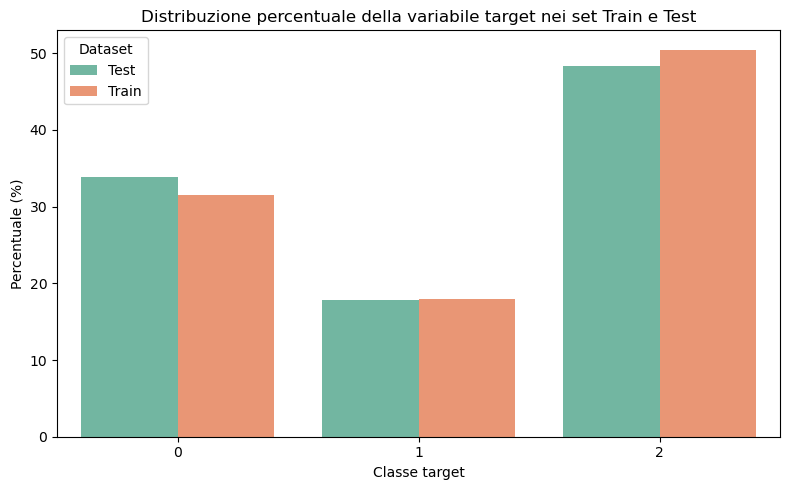

In [26]:
from sklearn.model_selection import train_test_split

X = stud_selected.drop('Target_encoded', axis=1)  
y = stud_selected['Target_encoded']  

# Split the data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# === Visualizzazione distribuzione target ===
# Ricrea il DataFrame con etichette
dist_df = pd.DataFrame({
    'Set': ['Train'] * len(y_train) + ['Test'] * len(y_test),
    'Target': pd.concat([y_train, y_test])
})

# Calcola le percentuali
percent_df = (
    dist_df.value_counts(['Set', 'Target'])
    .reset_index(name='Count')
    .groupby('Set')
    .apply(lambda x: x.assign(Percentage=100 * x['Count'] / x['Count'].sum()))
    .reset_index(drop=True)
)

# Plot percentuale
plt.figure(figsize=(8, 5))
sns.barplot(data=percent_df, x='Target', y='Percentage', hue='Set', palette='Set2')
plt.title('Distribuzione percentuale della variabile target nei set Train e Test')
plt.xlabel('Classe target')
plt.ylabel('Percentuale (%)')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# Model comparison

1- FeaturesTrasformer (create new features)

2 - preprocessing (Standard Scaler, OneHot)

3- SelectPercentile (percentile=75, filtro per evitare overfitting)

4- RFECV / selectFromModel(alg tree-based)

5- SMOTE

5- model 

Provare con e senza feature selection

Decidere le metriche da valutare e stampare 

| Metrica               | Quando usarla                                   |
| --------------------- | ----------------------------------------------- |
| **Accuracy**          | Classi bilanciate, visione generale             |
| **F1-macro/Precision/Recall**          | Performance uguale su tutte le classi       |
| **F1-weighted/Precision/Recall**       | Se ti interessa anche il peso delle classi      |
| **Balanced Accuracy** | Quando ci sono classi sbilanciate         |
| **Confusion Matrix**  | Per capire dove sbaglia il modello          |
| **ROC AUC**           | Se lavori con probabilità e vuoi valutare curve |


precision_macro = media(precision per ciascuna classe) <br>
recall_macro = media(recall per ciascuna classe) <br>
f1_macro = media(F1 per ciascuna classe) 

precision_weighted = somma(precision_i * supporto_i) / totale


## Before features selection

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9118
[LightGBM] [Info] Number of data points in the train set: 4017, number of used features: 107
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9288
[LightGBM] [Info] Number of data points in the train set: 4020, number of used features: 106
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002538 sec

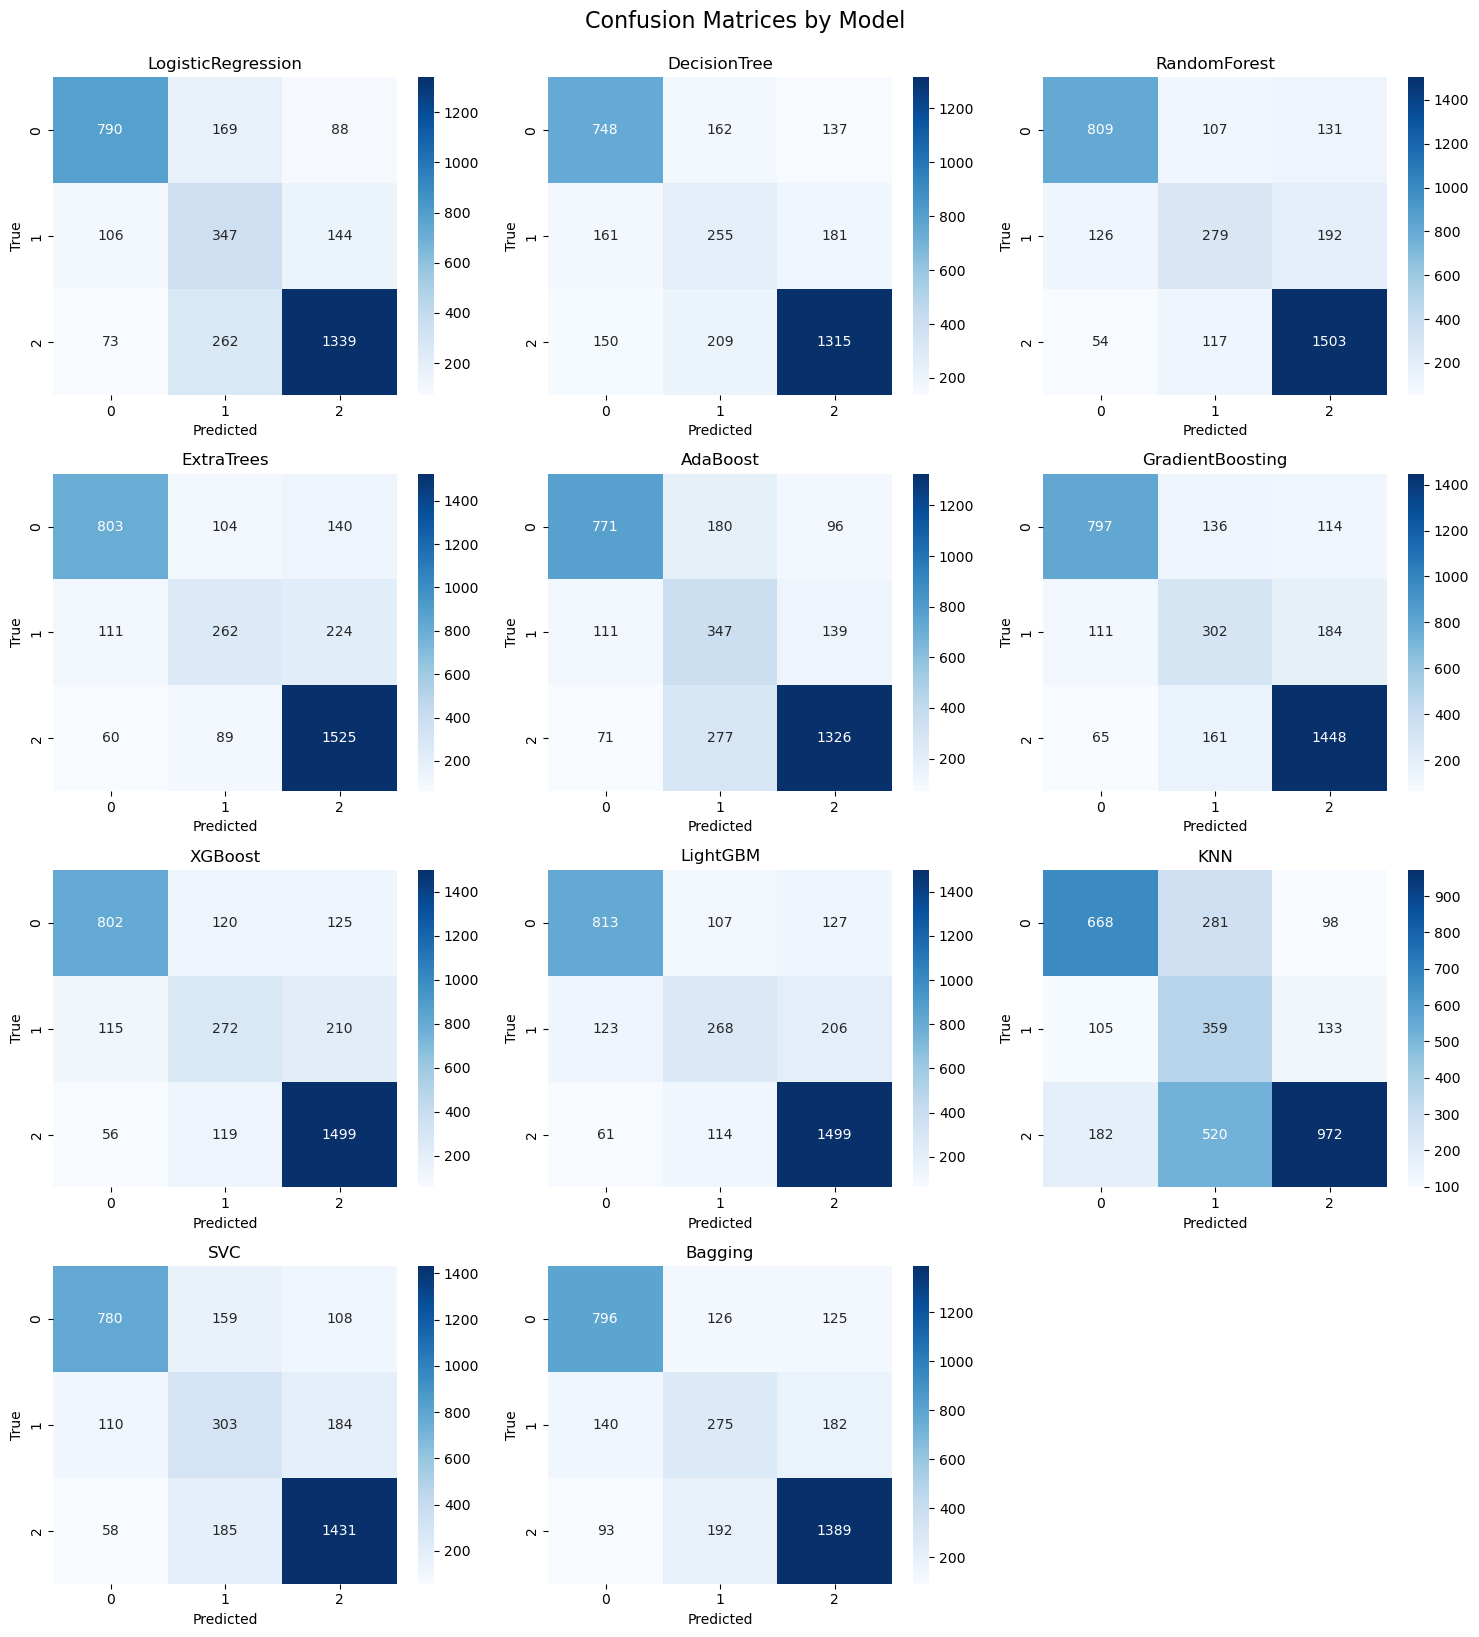

                 Model  Precision_macro  Recall_macro  F1_macro  \
2         RandomForest         0.731927      0.712623  0.720275   
3           ExtraTrees         0.735855      0.705602  0.716258   
7             LightGBM         0.727245      0.706958  0.714720   
5     GradientBoosting         0.717538      0.710693  0.713636   
6              XGBoost         0.724628      0.705690  0.713217   
0   LogisticRegression         0.704537      0.711886  0.704576   
9                  SVC         0.707209      0.702454  0.703867   
4             AdaBoost         0.696691      0.703248  0.695381   
10             Bagging         0.685432      0.683551  0.684459   
1         DecisionTree         0.639647      0.642367  0.640880   
8                  KNN         0.605646      0.606666  0.583896   

    Precision_weighted  Recall_weighted  F1_weighted  Balanced_Accuracy  \
2             0.773198         0.780892     0.775351           0.712623   
3             0.771061         0.780591     0

In [21]:
# Core libraries
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline      import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier, GradientBoostingClassifier,
                              BaggingClassifier, VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix,  balanced_accuracy_score,  roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


from FeaturesTrasformer import FeaturesTransformer
from preprocessor import preprocessor

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



# --- Model 
models = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(kernel="rbf", probability=True),
    #"GaussianNB": GaussianNB(),
    "Bagging": BaggingClassifier(random_state=42)
    
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Per salvare le confusion matrix
confusion_matrices = []
model_names = []

results_summary = []
detailed_results = []

for name, model in models.items():
    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    for train_idx, test_idx in skf.split(X_train, y_train):
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_test = X_train.iloc[test_idx]
        y_fold_test = y_train.iloc[test_idx]

        pipeline = Pipeline(steps=[
            ('feature_transformer', FeaturesTransformer(drop_originals=True)),
            ('preprocessing', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('model', model)
        ])

        pipeline.fit(X_fold_train, y_fold_train)
        y_pred = pipeline.predict(X_fold_test)
        
        try:
            y_prob = pipeline.predict_proba(X_fold_test)
            y_prob_all.extend(y_prob)
        except:
            # Se il modello non supporta predict_proba
            y_prob_all = None

        y_true_all.extend(y_fold_test)
        y_pred_all.extend(y_pred)


    # Report + Balanced Accuracy
    report = classification_report(y_true_all, y_pred_all, output_dict=True, zero_division=0)
    bal_acc = balanced_accuracy_score(y_true_all, y_pred_all)

    # AUC
    auc_macro = np.nan
    auc_weighted = np.nan
    if y_prob_all is not None:
        try:
            auc_macro = roc_auc_score(y_true_all, np.array(y_prob_all), multi_class='ovr', average='macro')
            auc_weighted = roc_auc_score(y_true_all, np.array(y_prob_all), multi_class='ovr', average='weighted')
        except:
            pass

    results_summary.append({
        "Model": name,
        "Precision_macro": report['macro avg']['precision'],
        "Recall_macro": report['macro avg']['recall'],
        "F1_macro": report['macro avg']['f1-score'],
        "Precision_weighted": report['weighted avg']['precision'],
        "Recall_weighted": report['weighted avg']['recall'],
        "F1_weighted": report['weighted avg']['f1-score'],
        "Balanced_Accuracy": bal_acc,
        "AUC_macro": auc_macro,
        "AUC_weighted": auc_weighted
    })

    for label in report:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            detailed_results.append({
                "Model": name,
                "Class": label,
                "Precision": report[label]['precision'],
                "Recall": report[label]['recall'],
                "F1-score": report[label]['f1-score'],
                "Support": report[label]['support']
            })

    cm = confusion_matrix(y_true_all, y_pred_all)
    confusion_matrices.append(cm)
    model_names.append(name)

# === Visualizza tutte le confusion matrix ===
n_models = len(confusion_matrices)
cols = 3
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for i, cm in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{model_names[i]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Confusion Matrices by Model", fontsize=16, y=1.02)
plt.show()

# Mostra e salva i risultati
results_df = pd.DataFrame(results_summary).sort_values("F1_macro", ascending=False)
print(results_df)

detailed_df = pd.DataFrame(detailed_results)
print(detailed_df)


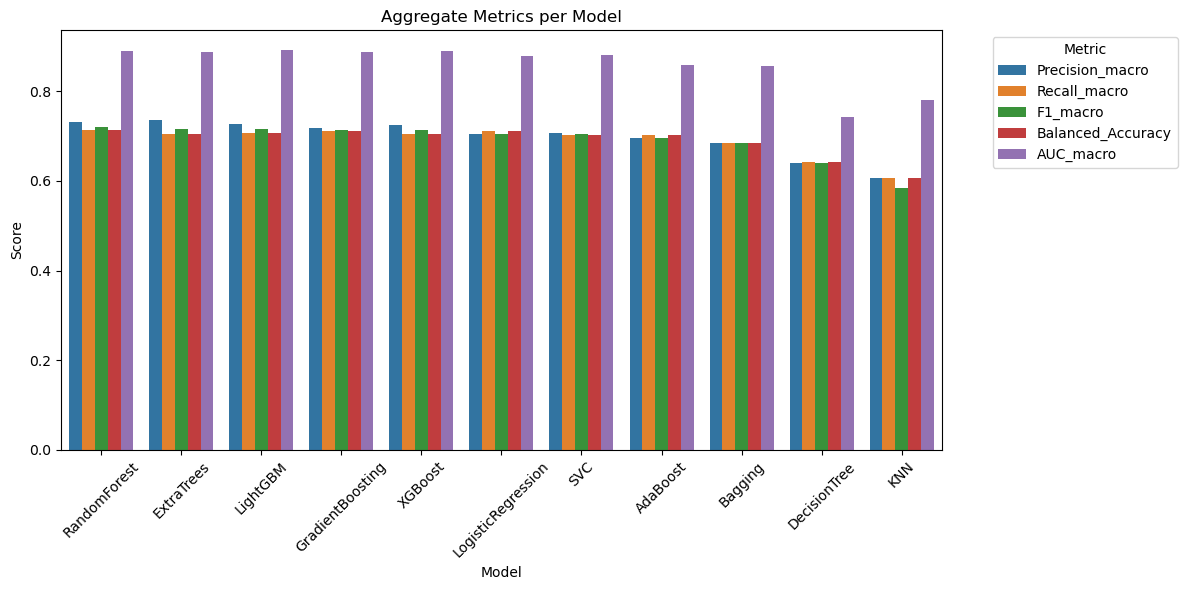

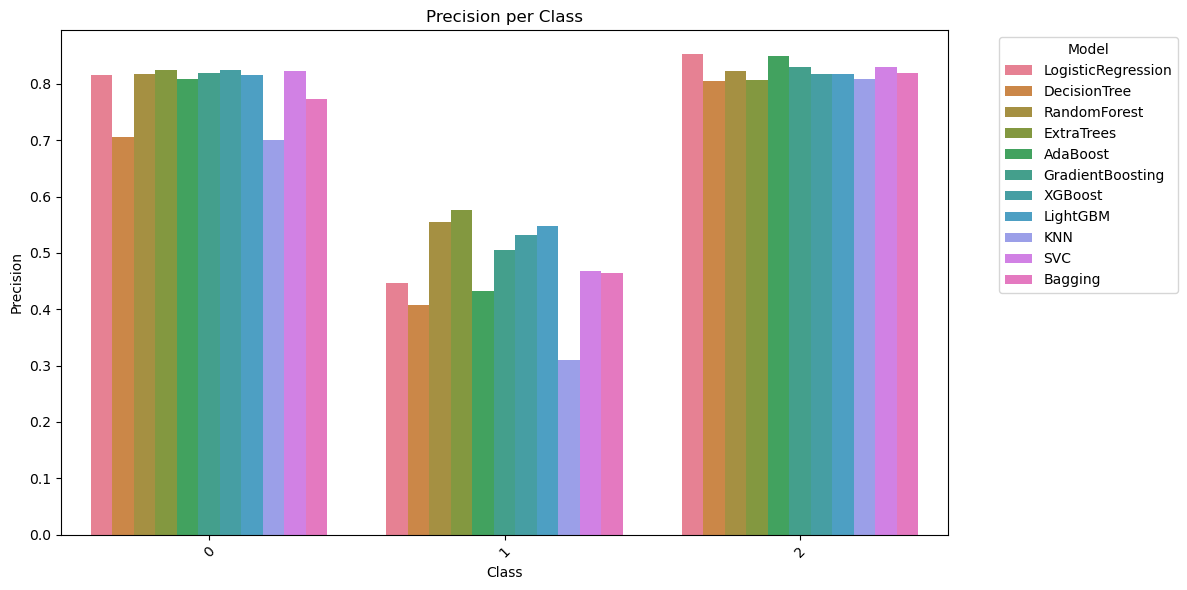

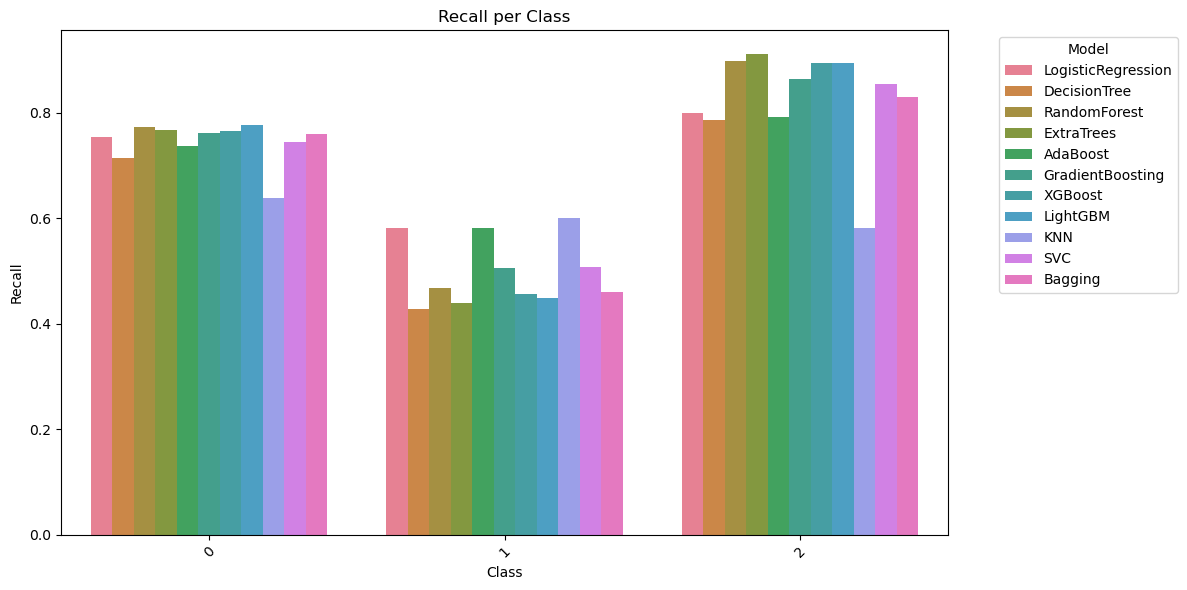

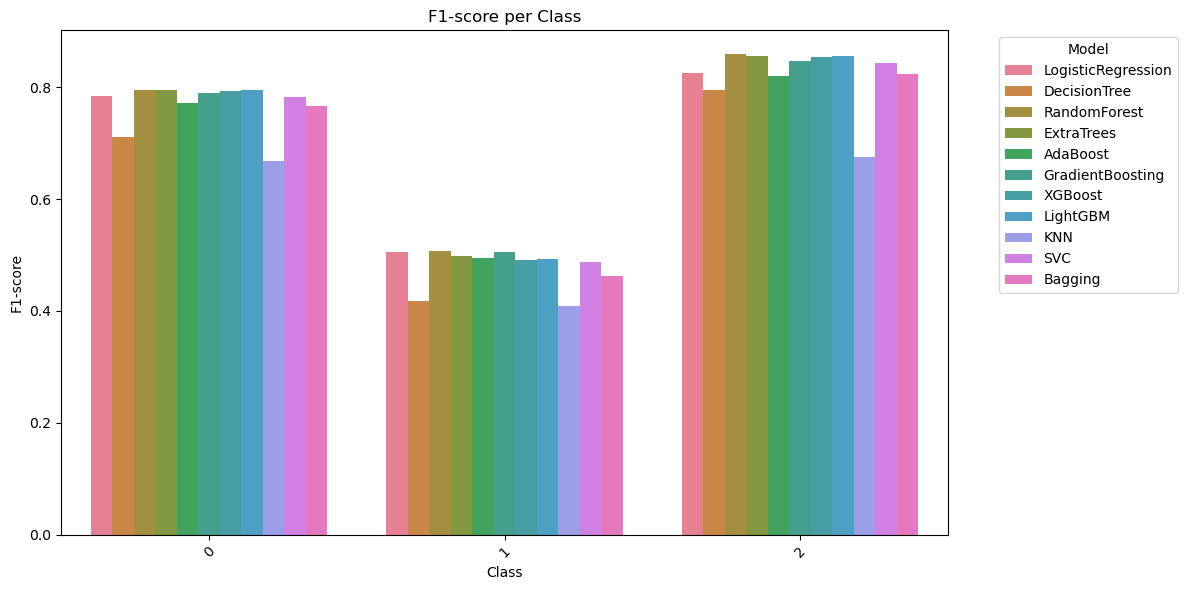

In [22]:

import matplotlib.pyplot as plt
import seaborn as sns

# Seleziona le metriche da visualizzare
metrics = ['Precision_macro', 'Recall_macro', 'F1_macro', 'Balanced_Accuracy','AUC_macro']
results_melted = results_df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.xticks(rotation=45)
plt.title('Aggregate Metrics per Model')
plt.ylabel('Score')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Seleziona le metriche per classe
class_metrics = ['Precision', 'Recall', 'F1-score']
for metric in class_metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=detailed_df, x='Class', y=metric, hue='Model')
    plt.title(f'{metric} per Class')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


## Freatures selection (k=30)

Fold 1 - Selected features:
['num__Application_order' 'num__Previous_qualification_grade'
 'num__Admission_grade' 'num__Age' 'num__avg_grade' 'num__pass_rate_1st'
 'num__pass_rate_2nd' 'num__pass_rate_delta' 'num__grade_delta'
 'num__approved_delta' 'num__total_enrolled' 'num__total_credited'
 'num__eval_completion_rate_1st' 'num__eval_completion_rate_2nd'
 'num__eval_completion_delta' 'bin__Debtor' 'bin__Tuition_fees_up_to_date'
 'bin__Gender' 'bin__Scholarship_holder' 'oh__Application_mode_7'
 'oh__Application_mode_39' 'oh__Course_9119' 'oh__Course_9238'
 'oh__Course_9500' 'oh__Course_9991' 'oh__Previous_qualification_3'
 'oh__Previous_qualification_19' 'oh__Mother_occupation_90'
 'oh__Father_qualification_34' 'oh__Mother_qualification_34']

Fold 2 - Selected features:
['num__Application_order' 'num__Previous_qualification_grade'
 'num__Admission_grade' 'num__Age' 'num__Unemployment_rate' 'num__GDP'
 'num__avg_grade' 'num__pass_rate_1st' 'num__pass_rate_2nd'
 'num__pass_rate_delta' '

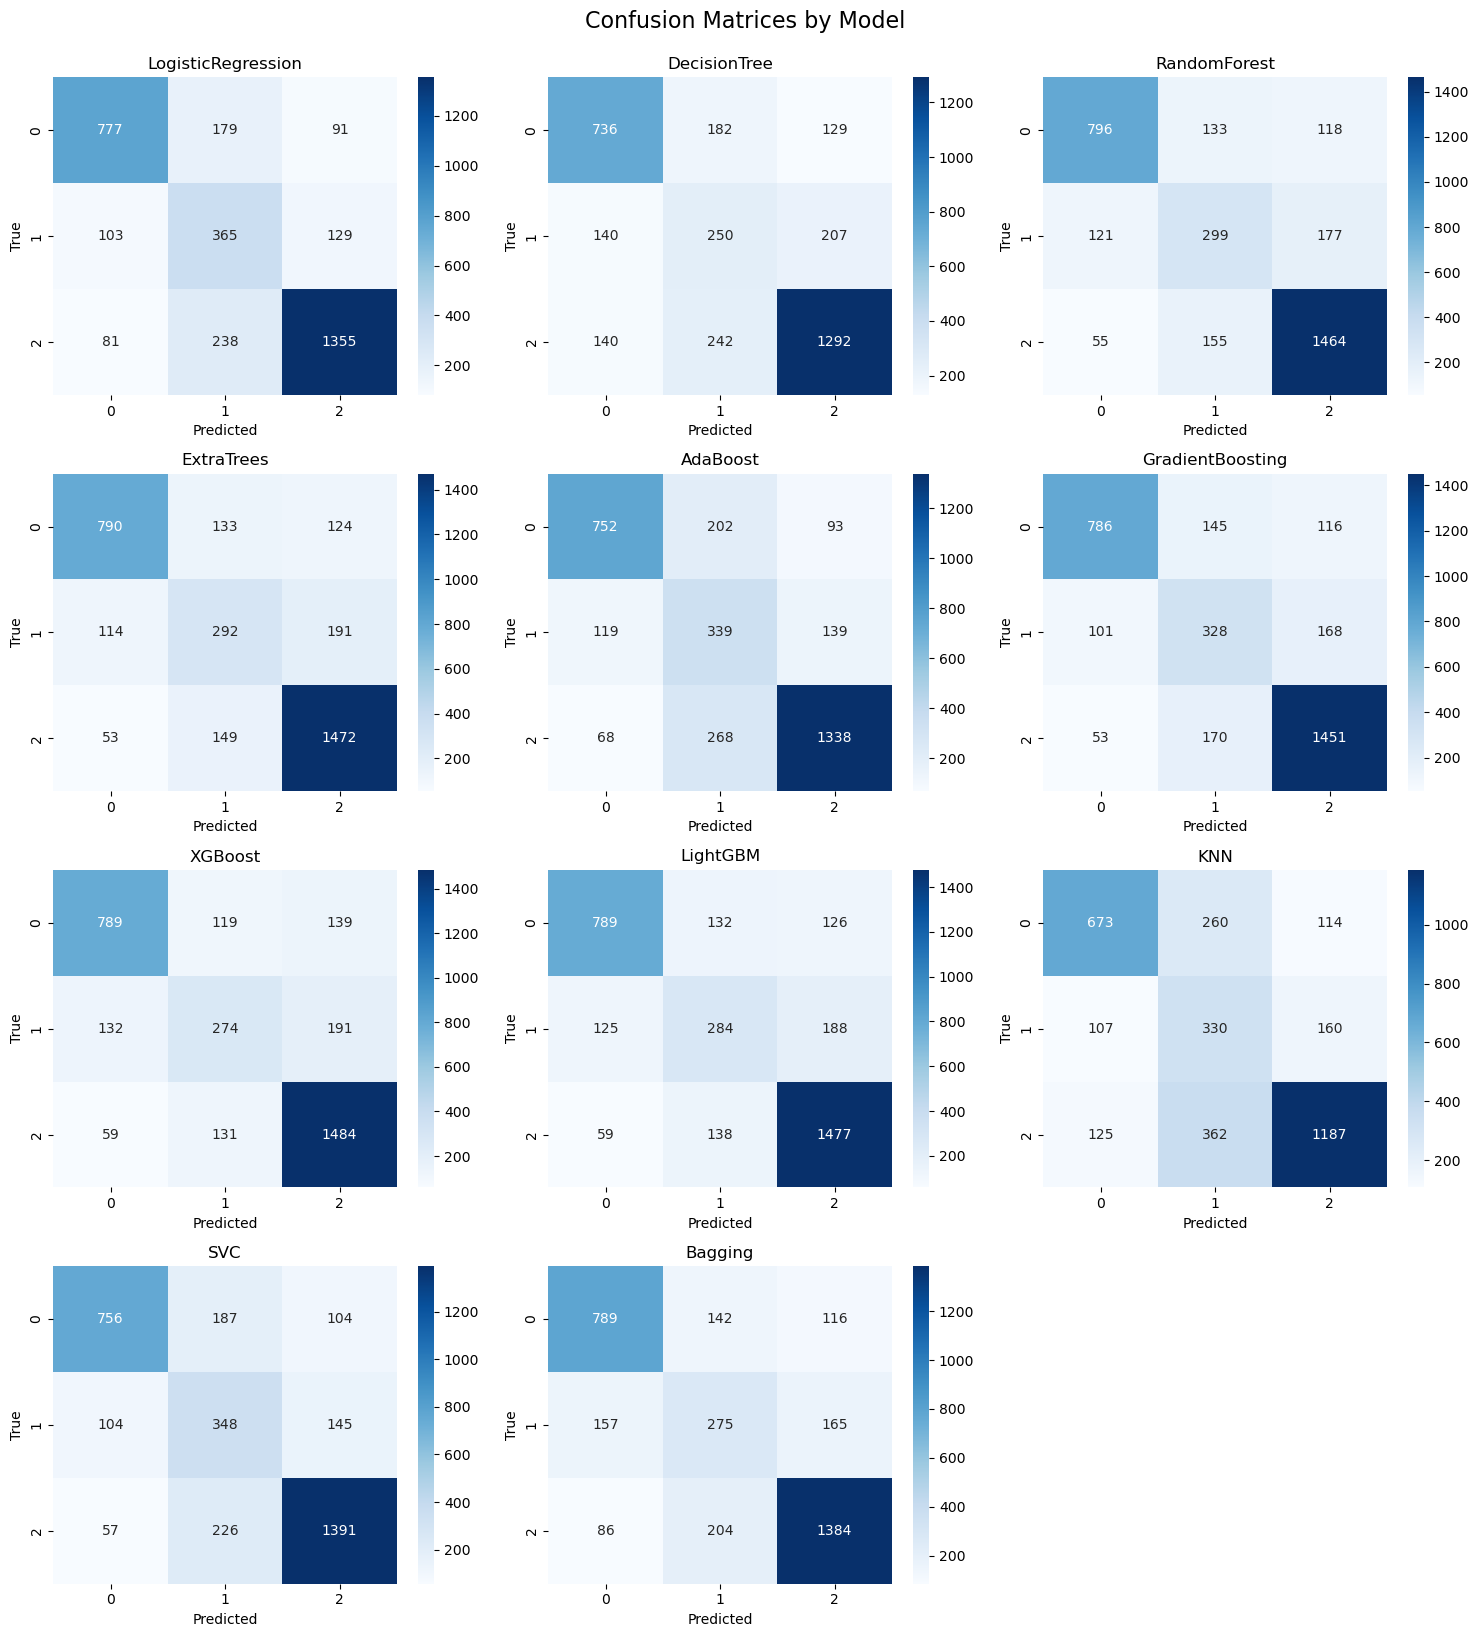

                 Model  Precision_macro  Recall_macro  F1_macro  \
5     GradientBoosting         0.727530      0.722305  0.723817   
2         RandomForest         0.720197      0.711886  0.715492   
3           ExtraTrees         0.719311      0.707660  0.712588   
0   LogisticRegression         0.711867      0.720983  0.712459   
7             LightGBM         0.716069      0.703870  0.709066   
9                  SVC         0.709964      0.711974  0.707282   
6              XGBoost         0.715361      0.699681  0.706086   
4             AdaBoost         0.690706      0.695122  0.688143   
10             Bagging         0.679533      0.680327  0.679856   
1         DecisionTree         0.629647      0.631175  0.629824   
8                  KNN         0.634247      0.634878  0.624296   

    Precision_weighted  Recall_weighted  F1_weighted  Balanced_Accuracy  \
5             0.777574         0.773056     0.774320           0.722305   
2             0.769972         0.771248     0

In [23]:
# Core libraries
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from imblearn.over_sampling import SMOTE
from imblearn.pipeline      import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier, GradientBoostingClassifier,
                              BaggingClassifier, VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix,  balanced_accuracy_score,  roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


from FeaturesTrasformer import FeaturesTransformer
from preprocessor import preprocessor

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)



# --- Model 
models = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(kernel="rbf", probability=True),
    #"GaussianNB": GaussianNB(),
    "Bagging": BaggingClassifier(random_state=42)
    
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Per salvare le confusion matrix
confusion_matrices = []
model_names = []

results_summary = []
detailed_results = []

selected_features_per_model = {}

for name, model in models.items():
    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    selected_features_per_model[name] = {}

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_test = X_train.iloc[test_idx]
        y_fold_test = y_train.iloc[test_idx]

        pipeline = Pipeline(steps=[
            ('feature_transformer', FeaturesTransformer(drop_originals=True)),
            ('preprocessing', preprocessor),
            ('select', SelectKBest(score_func=mutual_info_classif, k=30)),
            ('smote', SMOTE(random_state=42)),
            ('model', model)
        ])

        pipeline.fit(X_fold_train, y_fold_train)
        y_pred = pipeline.predict(X_fold_test)
        
        try:
            y_prob = pipeline.predict_proba(X_fold_test)
            y_prob_all.extend(y_prob)
        except:
            # Se il modello non supporta predict_proba
            y_prob_all = None

        y_true_all.extend(y_fold_test)
        y_pred_all.extend(y_pred)

        # === Estrai e salva le feature selezionate ===
        select_step = pipeline.named_steps['select']
        preprocessing_step = pipeline.named_steps['preprocessing']
        
        try:
            feature_names = preprocessing_step.get_feature_names_out()
        except:
            feature_names = X_fold_train.columns  # fallback

        selected_mask = select_step.get_support()
        selected_features = feature_names[selected_mask]

        print(f"Fold {fold} - Selected features:\n{selected_features}\n")
        selected_features_per_model[name][f"fold_{fold}"] = list(selected_features)


    # Report + Balanced Accuracy
    report = classification_report(y_true_all, y_pred_all, output_dict=True, zero_division=0)
    bal_acc = balanced_accuracy_score(y_true_all, y_pred_all)

    # AUC
    auc_macro = np.nan
    auc_weighted = np.nan
    if y_prob_all is not None:
        try:
            auc_macro = roc_auc_score(y_true_all, np.array(y_prob_all), multi_class='ovr', average='macro')
            auc_weighted = roc_auc_score(y_true_all, np.array(y_prob_all), multi_class='ovr', average='weighted')
        except:
            pass

    results_summary.append({
        "Model": name,
        "Precision_macro": report['macro avg']['precision'],
        "Recall_macro": report['macro avg']['recall'],
        "F1_macro": report['macro avg']['f1-score'],
        "Precision_weighted": report['weighted avg']['precision'],
        "Recall_weighted": report['weighted avg']['recall'],
        "F1_weighted": report['weighted avg']['f1-score'],
        "Balanced_Accuracy": bal_acc,
        "AUC_macro": auc_macro,
        "AUC_weighted": auc_weighted
    })

    for label in report:
        if label not in ['accuracy', 'macro avg', 'weighted avg']:
            detailed_results.append({
                "Model": name,
                "Class": label,
                "Precision": report[label]['precision'],
                "Recall": report[label]['recall'],
                "F1-score": report[label]['f1-score'],
                "Support": report[label]['support']
            })

    cm = confusion_matrix(y_true_all, y_pred_all)
    confusion_matrices.append(cm)
    model_names.append(name)

# === Visualizza tutte le confusion matrix ===
n_models = len(confusion_matrices)
cols = 3
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for i, cm in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{model_names[i]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Confusion Matrices by Model", fontsize=16, y=1.02)
plt.show()

# Mostra e salva i risultati
results_df = pd.DataFrame(results_summary).sort_values("F1_macro", ascending=False)
print(results_df)

detailed_df = pd.DataFrame(detailed_results)
print(detailed_df)


# Model evaluation

ExtraTrees / Random Forest sono il baseline “robusto” (miglior equilibrio su tutte le metriche).

LightGBM / XGBoost competono praticamente alla pari, con vantaggio di velocità e facilità di tun­ing.

La classe intermedia rimane il punto debole: senza interventi specifici, nessun modello supera F1 ≈ 0.55.

Con metriche macro intorno a 0.74 e AUC macro ≈ 0.90, le soluzioni attuali sono già utilizzabili per un sistema di allerta precoce, ma c’è margine di miglioramento tramite ribilanciamento e stacking.

In [30]:
# ============================================
# 1. Imports
# ============================================
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE                 # SMOTE works out-of-the-box for multiclass
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             classification_report,
                             confusion_matrix)
from sklearn.ensemble import RandomForestClassifier

from FeaturesTrasformer import FeaturesTransformer
from preprocessor import preprocessor

# ============================================
# 2. Build the pipeline
# ============================================
# pipeline = Pipeline(steps=[
#     ('feature_transformer', FeaturesTransformer(drop_originals=True)),      
#     ("preprocessor",         preprocessor),              
#     ("smote",                SMOTE(random_state=42)),    # balances all minority classes
#     ("model",                RandomForestClassifier(
#                                  n_estimators=300,
#                                  class_weight="balanced",  # extra safety net for imbalance
#                                  random_state=42))
# ])

pipeline = Pipeline(steps=[
    ('feature_transformer', FeaturesTransformer(drop_originals=True)),      
    ("preprocessor",         preprocessor),              
    ("smote",                SMOTE(random_state=42)),    # balances all minority classes
    ("model",                ExtraTreesClassifier(random_state=42, n_estimators=300, class_weight="balanced") )
                                 
])



# ============================================
# 3. Fit the model
# ============================================
pipeline.fit(X_train, y_train)

# ============================================
# 4. Predict
# ============================================
y_pred  = pipeline.predict(X_test)           # shape (n_samples,)
y_proba = pipeline.predict_proba(X_test)     # shape (n_samples, n_classes)

# ============================================
# 5. Compute evaluation metrics (macro)
# ============================================
accuracy        = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
recall_macro    = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_macro        = f1_score(y_test, y_pred, average="macro", zero_division=0)

# ROC-AUC (macro, One-vs-Rest)
roc_auc_macro   = roc_auc_score(y_test, y_proba,
                                multi_class="ovr",       # can switch to "ovo" if desired
                                average="macro")

# ============================================
# 6. Pack results in a DataFrame
# ============================================
results = pd.DataFrame({
    "Model":            ["ExtraTreesClassifier"],
    "Accuracy":         [accuracy],
    "Precision_macro":  [precision_macro],
    "Recall_macro":     [recall_macro],
    "F1_macro":         [f1_macro],
    "ROC_AUC_macro":    [roc_auc_macro]
})

print(results.round(3))          # quick display

# ============================================
# 7. Optional detailed diagnostics
# ============================================
print("\nClassification report (per class):\n",
      classification_report(y_test, y_pred, digits=3))

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


                  Model  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0  ExtraTreesClassifier     0.776            0.728         0.692     0.702   

   ROC_AUC_macro  
0          0.884  

Classification report (per class):
               precision    recall  f1-score   support

           0      0.824     0.762     0.792       374
           1      0.567     0.386     0.459       197
           2      0.794     0.929     0.856       535

    accuracy                          0.776      1106
   macro avg      0.728     0.692     0.702      1106
weighted avg      0.764     0.776     0.764      1106

Confusion matrix:
 [[285  37  52]
 [ 44  76  77]
 [ 17  21 497]]



Classification report for RandomForestClassifier:
              precision    recall  f1-score   support

           0      0.792     0.765     0.778       374
           1      0.503     0.391     0.440       197
           2      0.811     0.897     0.852       535

    accuracy                          0.762      1106
   macro avg      0.702     0.684     0.690      1106
weighted avg      0.750     0.762     0.754      1106


Classification report for ExtraTreesClassifier:
              precision    recall  f1-score   support

           0      0.818     0.767     0.792       374
           1      0.547     0.386     0.452       197
           2      0.799     0.920     0.855       535

    accuracy                          0.773      1106
   macro avg      0.721     0.691     0.700      1106
weighted avg      0.760     0.773     0.762      1106


Summary macro metrics:
                     Model  Accuracy  Precision_macro  Recall_macro  F1_macro  \
0  RandomForestClassifier     0.7

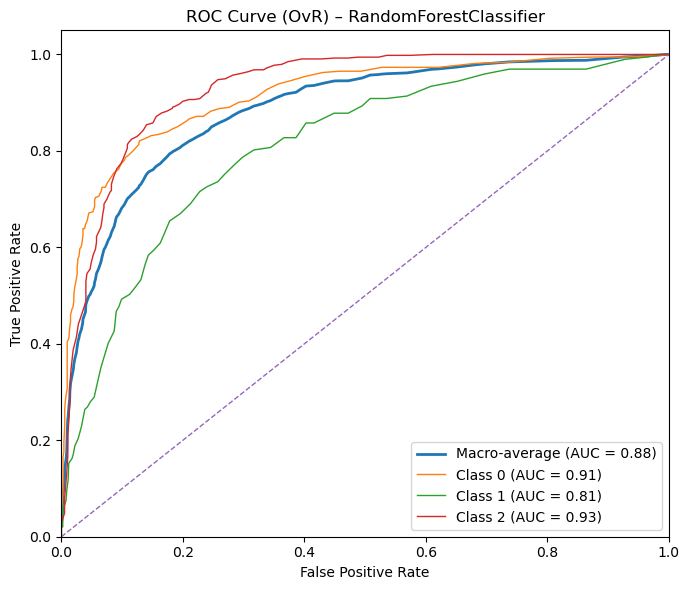

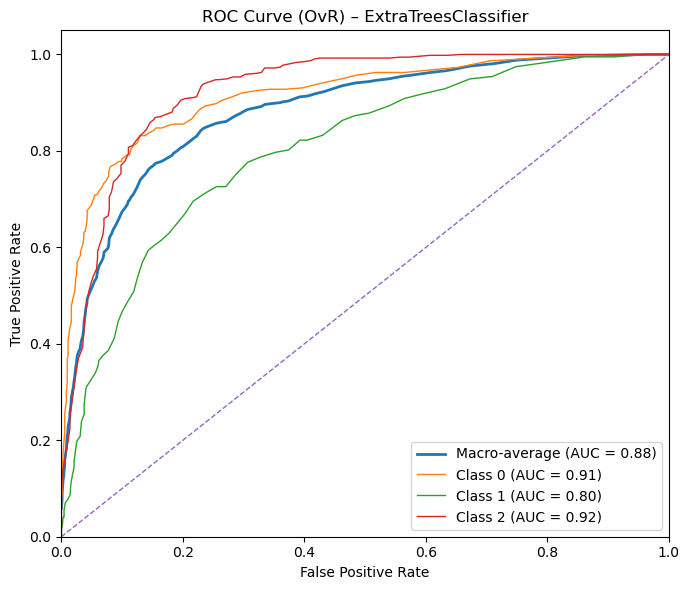

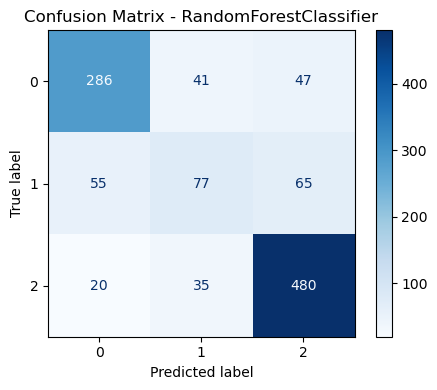

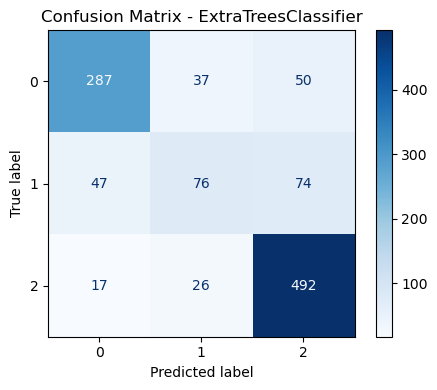

In [ ]:
# ---------------------------------------------------------------
# RandomForest vs ExtraTrees – metrics, classification report,
# and One-vs-Rest ROC curves
# ---------------------------------------------------------------
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize

import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ----------------------------------------------------------------
# Helper: build the common pipeline
# ----------------------------------------------------------------
def build_pipeline(model):
    """Return an imblearn Pipeline with the chosen estimator."""
    return Pipeline(steps=[
        ("feature_transformer", FeaturesTransformer(drop_originals=True)),
        ("preprocessor",        preprocessor),
        ("smote",               SMOTE(random_state=42)),
        ("model",               model)
    ])

# ----------------------------------------------------------------
# Helper: evaluate a single model
# ----------------------------------------------------------------
def evaluate_one(model_name, model, classes):
    """
    Fit the pipeline, print classification report,
    compute macro metrics, return predicted probabilities.
    """
    pl = build_pipeline(model)
    pl.fit(X_train, y_train)

    y_pred  = pl.predict(X_test)
    y_proba = pl.predict_proba(X_test)

    # ---- detailed per-class report ----
    print(f"\nClassification report for {model_name}:\n"
          f"{classification_report(y_test, y_pred, digits=3)}")

    # ---- macro metrics for the summary table ----
    metrics = {
        "Model":            model_name,
        "Accuracy":         accuracy_score(y_test, y_pred),
        "Precision_macro":  precision_score(y_test, y_pred, average="macro",
                                            zero_division=0),
        "Recall_macro":     recall_score(y_test, y_pred, average="macro",
                                         zero_division=0),
        "F1_macro":         f1_score(y_test, y_pred, average="macro",
                                     zero_division=0),
        "ROC_AUC_macro":    roc_auc_score(y_test, y_proba,
                                          multi_class="ovr",
                                          average="macro")
    }
    return metrics, y_proba

# ----------------------------------------------------------------
# Helper: plot multi-class ROC (OvR)
# ----------------------------------------------------------------
def plot_multiclass_roc(model_name, classes, y_test_bin, y_score):
    """
    Draw One-vs-Rest ROC curves for each class plus the macro-average.
    Each call produces its own figure, respecting the 'one chart per plot'
    guideline.
    """
    n_classes = len(classes)

    # Per-class ROC
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    roc_auc["macro"] = auc(all_fpr, mean_tpr)

    # ------------------------ plot ------------------------
    plt.figure(figsize=(7, 6))
    plt.plot(all_fpr, mean_tpr,
             label=f"Macro-average (AUC = {roc_auc['macro']:.2f})",
             linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})",
                 linewidth=1)

    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (OvR) – {model_name}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------
# 1. Run both models
# ----------------------------------------------------------------
unique_classes = np.unique(y_train)               # keeps ordering stable
y_test_bin     = label_binarize(y_test, classes=unique_classes)

rf_metrics, rf_proba = evaluate_one(
    "RandomForestClassifier",
    RandomForestClassifier(class_weight="balanced",
                           random_state=42),
    unique_classes)

et_metrics, et_proba = evaluate_one(
    "ExtraTreesClassifier",
    ExtraTreesClassifier(class_weight="balanced",
                         random_state=42),
    unique_classes)

# ----------------------------------------------------------------
# 2. Summary table
# ----------------------------------------------------------------
results = pd.DataFrame([rf_metrics, et_metrics])
print("\nSummary macro metrics:\n", results.round(3))


# ----------------------------------------------------------------
# 4. ROC curves (one figure per model, no subplots)
# ----------------------------------------------------------------
plot_multiclass_roc("RandomForestClassifier",
                    unique_classes, y_test_bin, rf_proba)

plot_multiclass_roc("ExtraTreesClassifier",
                    unique_classes, y_test_bin, et_proba)


# Print confusion matrices for both models
fig_rf, ax_rf = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, np.argmax(rf_proba, axis=1), display_labels=unique_classes, ax=ax_rf, cmap="Blues"
)
ax_rf.set_title("Confusion Matrix - RandomForestClassifier")
plt.tight_layout()
plt.show()

fig_et, ax_et = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, np.argmax(et_proba, axis=1), display_labels=unique_classes, ax=ax_et, cmap="Blues"
)
ax_et.set_title("Confusion Matrix - ExtraTreesClassifier")
plt.tight_layout()
plt.show()

# Hyper-Parameter Tuning 


In [ ]:
# ---------------------------------------------------------------
# Hyper-parameter tuning with GridSearchCV for
# RandomForestClassifier and ExtraTreesClassifier
# ---------------------------------------------------------------
# Prerequisites already defined in memory:
#   X_train, X_test, y_train, y_test,
#   preprocessor, FeaturesTransformer
# ---------------------------------------------------------------

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score)
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")           # silence convergence warnings

# ---------------------------------------------------------------
# 1. Common pipeline builder
# ---------------------------------------------------------------
def build_pipeline(base_estimator):
    """Return an imblearn Pipeline with the chosen estimator."""
    return Pipeline(steps=[
        ("feature_transformer", FeaturesTransformer(drop_originals=True)),
        ("preprocessor",        preprocessor),
        ("smote",               SMOTE(random_state=42)),
        ("model",               base_estimator)
    ])

# ---------------------------------------------------------------
# 2. Parameter grids
# ---------------------------------------------------------------
param_grid_rf = {
    "model__n_estimators":     [200, 300, 500],
    "model__max_depth":        [None, 10, 20, 30],
    "model__max_features":     ["sqrt", "log2"],
    "model__min_samples_split":[2, 5, 10]
}

param_grid_et = {
    "model__n_estimators":     [200, 300, 500],
    "model__max_depth":        [None, 10, 20, 30],
    "model__max_features":     ["sqrt", "log2"],
    "model__min_samples_split":[2, 5, 10]
}

# ---------------------------------------------------------------
# 3. Cross-validation strategy
# ---------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---------------------------------------------------------------
# 4. GridSearch for RandomForest
# ---------------------------------------------------------------
gs_rf = GridSearchCV(
    estimator = build_pipeline(RandomForestClassifier(
                    class_weight="balanced",
                    random_state=42)),
    param_grid = param_grid_rf,
    scoring    = "f1_macro",     # change if you prefer another metric
    cv         = cv,
    n_jobs     = -1,
    verbose    = 1
)
gs_rf.fit(X_train, y_train)
print(f"\nBest RF params: {gs_rf.best_params_}")
print(f"Best CV f1_macro: {gs_rf.best_score_:.3f}")

# ---------------------------------------------------------------
# 5. GridSearch for ExtraTrees
# ---------------------------------------------------------------
gs_et = GridSearchCV(
    estimator = build_pipeline(ExtraTreesClassifier(
                    class_weight="balanced",
                    random_state=42)),
    param_grid = param_grid_et,
    scoring    = "f1_macro",
    cv         = cv,
    n_jobs     = -1,
    verbose    = 1
)
gs_et.fit(X_train, y_train)
print(f"\nBest ET params: {gs_et.best_params_}")
print(f"Best CV f1_macro: {gs_et.best_score_:.3f}")

# ---------------------------------------------------------------
# 6. Evaluate the best estimators on the hold-out test set
# ---------------------------------------------------------------
def evaluate_best(gs, model_name):
    """Compute classification metrics on the test set."""
    y_pred  = gs.predict(X_test)
    y_proba = gs.predict_proba(X_test)

    metrics = {
        "Model":            model_name,
        "Accuracy":         accuracy_score(y_test, y_pred),
        "Precision_macro":  precision_score(y_test, y_pred, average="macro",
                                            zero_division=0),
        "Recall_macro":     recall_score(y_test, y_pred, average="macro",
                                         zero_division=0),
        "F1_macro":         f1_score(y_test, y_pred, average="macro",
                                     zero_division=0),
        "ROC_AUC_macro":    roc_auc_score(y_test, y_proba,
                                          multi_class="ovr",
                                          average="macro")
    }
    print(f"\nClassification report for {model_name} (best estimator):\n",
          classification_report(y_test, y_pred, digits=3))
    return metrics

rf_metrics = evaluate_best(gs_rf, "RandomForest (tuned)")
et_metrics = evaluate_best(gs_et, "ExtraTrees (tuned)")

# ---------------------------------------------------------------
# 7. Summary table of tuned performance
# ---------------------------------------------------------------
summary = pd.DataFrame([rf_metrics, et_metrics])
print("\nTuned model performance on the test set:\n",
      summary.round(3))



Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best RF params: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV f1_macro: 0.728
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best ET params: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 500}
Best CV f1_macro: 0.726

Classification report for RandomForest (tuned) (best estimator):
               precision    recall  f1-score   support

           0      0.805     0.773     0.789       374
           1      0.517     0.462     0.488       197
           2      0.828     0.884     0.855       535

    accuracy                          0.771      1106
   macro avg      0.717     0.706     0.711      1106
weighted avg      0.765     0.771     0.767      1106


Classification report for ExtraTrees (tuned) (best estimator):
               precision    recall  f1-score   suppo